## Import needed packages

In [1]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score, mean_absolute_percentage_error
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import pandas as pd
import numpy as np
import time
import os

In [2]:
# Set option to display all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.6f}'.format)

## Define features and target

In [3]:
categorical_features = [
    "OP_CARRIER_AIRLINE_ID",
    "TAIL_NUM",
    "OP_CARRIER_FL_NUM",

    "ORIGIN_AIRPORT_ID",
    "ORIGIN_CITY_MARKET_ID",
    "ORIGIN_STATE_FIPS",
    "ORIGIN_WAC",
    "DEST_AIRPORT_ID",
    "DEST_CITY_MARKET_ID",
    "DEST_STATE_FIPS",
    "DEST_WAC",
]

numerical_features = [
    "QUARTER",
    "MONTH",
    "DAY_OF_MONTH",
    "DAY_OF_WEEK",

    "CRS_DEP_TIME",
    "DEP_TIME_BLK",
    "CRS_ARR_TIME", 
    "ARR_TIME_BLK",
    "CRS_ELAPSED_TIME",
    "DISTANCE",
    "DISTANCE_GROUP",
]

target = "DEP_DELAY"

## Read training data from the year of 2022 and set type of categorical features to category

In [4]:
# Get the current script's directory
current_script_dir = os.getcwd()

# Move up to the parent directory
parent_dir = os.path.dirname(current_script_dir)

# Define the sibling data directory name
data_dir = os.path.join(parent_dir, 'data')

In [5]:
def set_categorical_dtype_to_str(
    dataframe: pd.DataFrame, 
    categorical_columns: list[str]
) -> pd.DataFrame:
    df = dataframe.copy()
    for column in categorical_columns:
        df[column] = df[column].astype('category')
    return df 

In [6]:
# Load the 2022 training datset
# Use os.path.join to create the full file path
training_dataset_filename = "encoded_training_dataset_2022.csv"
file_path = os.path.join(data_dir, training_dataset_filename)

# Read the CSV file into a DataFrame
training_dataset_df = pd.read_csv(file_path)
training_df = training_dataset_df[categorical_features+numerical_features+[target]].copy()

# Set dtype of categorical features to category
training_df = set_categorical_dtype_to_str(
    dataframe=training_df, 
    categorical_columns=categorical_features
)

# Display the description of dataset
display(training_df.describe())

,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,CRS_DEP_TIME,DEP_TIME_BLK,CRS_ARR_TIME,ARR_TIME_BLK,CRS_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP,DEP_DELAY
count,6551773.000000,6551773.000000,6551773.000000,6551773.000000,6551773.000000,6551773.000000,6551773.000000,6551773.000000,6551773.000000,6551773.000000,6551773.000000,6551773.000000
mean,2.525611,6.575482,15.731372,3.976177,1328.219585,8.024030,1486.236314,9.655784,143.059972,817.382685,3.740230,12.603955
std,1.103255,3.387474,8.757283,2.003274,491.535391,4.865378,519.240116,4.977613,72.606267,597.402761,2.341283,52.502743
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,31.000000,1.000000,-96.000000
25%,2.000000,4.000000,8.000000,2.000000,910.000000,4.000000,1101.000000,6.000000,90.000000,386.000000,2.000000,-5.000000
50%,3.000000,7.000000,16.000000,4.000000,1318.000000,8.000000,1512.000000,10.000000,125.000000,666.000000,3.000000,-2.000000
75%,3.000000,9.000000,23.000000,6.000000,1735.000000,12.000000,1921.000000,14.000000,174.000000,1052.000000,5.000000,10.000000
max,4.000000,12.000000,31.000000,7.000000,2359.000000,18.000000,2400.000000,18.000000,690.000000,5095.000000,11.000000,3433.000000


## Read testing data from the year of 2023 and set type of categorical features to category

In [7]:
# Load the 2023 testing datset
# Use os.path.join to create the full file path
testing_dataset_filename = "encoded_testing_dataset_2023.csv"
testing_file_path = os.path.join(data_dir, testing_dataset_filename)

# Read the CSV file into a DataFrame
testing_dataset_df = pd.read_csv(testing_file_path)
testing_df = testing_dataset_df[categorical_features+numerical_features+[target]].copy()

# Set dtype of categorical features to category
testing_df = set_categorical_dtype_to_str(
    dataframe=testing_df, 
    categorical_columns=categorical_features
)

# Display the description of dataset
display(testing_df.describe())

,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,CRS_DEP_TIME,DEP_TIME_BLK,CRS_ARR_TIME,ARR_TIME_BLK,CRS_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP,DEP_DELAY
count,6763366.000000,6763366.000000,6763366.000000,6763366.000000,6763366.000000,6763366.000000,6763366.000000,6763366.000000,6763366.000000,6763366.000000,6763366.000000,6763366.000000
mean,2.533025,6.599655,15.750670,3.983114,1331.043765,8.050420,1486.516154,9.665837,145.934768,833.977916,3.807604,12.285409
std,1.109902,3.412189,8.766607,2.001740,496.394849,4.914447,525.996117,5.026481,73.092890,599.873971,2.351688,55.328527
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,21.000000,1.000000,-99.000000
25%,2.000000,4.000000,8.000000,2.000000,909.000000,4.000000,1059.000000,5.000000,92.000000,399.000000,2.000000,-5.000000
50%,3.000000,7.000000,16.000000,4.000000,1321.000000,8.000000,1515.000000,10.000000,129.000000,679.000000,3.000000,-2.000000
75%,4.000000,10.000000,23.000000,6.000000,1740.000000,12.000000,1925.000000,14.000000,176.000000,1068.000000,5.000000,9.000000
max,4.000000,12.000000,31.000000,7.000000,2359.000000,18.000000,2400.000000,18.000000,1162.000000,5095.000000,11.000000,4413.000000


## Implement the experimental logic in the test method

In [8]:
def test_model(training_df, testing_df, features_columns, target_column):
    X_training = training_df[features_columns].values
    y_training = training_df[target_column].values

    X_testing = testing_df[features_columns].values
    y_testing = testing_df[target_column].values
    
    testing_results = {
        "metrics": {},
        "values": {}
    }
        
    model = xgb.XGBRegressor(
        enable_categorical=True,
        objective='reg:pseudohubererror',
        random_state=123,
        learning_rate=0.22,
        max_depth=8,
        min_child_weight=5,
        subsample= 0.81,
        colsample_bytree=0.79,
        n_estimators=950
    )
    model.fit(X_training, y_training)  
    y_pred = model.predict(X_testing)
    
    actual_values = list(y_testing)
    testing_results["values"]["actual"] = actual_values
    predicted_values = list(y_pred)
    testing_results["values"]["predicted"] = predicted_values
    errors = list(y_testing - y_pred)
    testing_results["values"]["errors"] = errors
    
    # Mean Absolute Error (MAE)
    mae = mean_absolute_error(actual_values, predicted_values)
    testing_results["metrics"]["mae"] = mae
    # Mean Squared Error (MSE)
    mse = mean_squared_error(actual_values, predicted_values)
    testing_results["metrics"]["mse"] = mse
    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)
    testing_results["metrics"]["rmse"] = rmse
    # R-squared (R²)
    r2 = r2_score(actual_values, predicted_values)
    testing_results["metrics"]["r2"] = r2
    # Adjusted R-squared (Note: requires model fit)
    n = len(actual_values)  # Number of data points
    p = len(features_columns)  # Number of predictors (features) used in the model
    r2_adj = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    testing_results["metrics"]["r2_adj"] = r2_adj
    # Mean Absolute Percentage Error (MAPE)
    mape = mean_absolute_percentage_error(actual_values, predicted_values) * 100
    testing_results["metrics"]["mape"] = mape
    # Explained Variance Score
    explained_variance = explained_variance_score(actual_values, predicted_values)
    testing_results["metrics"]["explained_variance"] = explained_variance
    # Huber Loss (delta=1.0, which is common)
    # Huber Loss is not directly available in scikit-learn, thus it has to be calculated manually
    delta = np.percentile(training_df[target_column].values, 95)
    huber_loss = np.mean(np.where(np.abs(np.array(actual_values) -  np.array(predicted_values)) <= delta, 
                                  0.5 * np.square(np.array(actual_values) -  np.array(predicted_values)), 
                                  delta * (np.abs(np.array(actual_values) -  np.array(predicted_values)) - 0.5 * delta)))
    testing_results["metrics"]["huber_loss"] = huber_loss
    # Quantile Loss (for quantile 0.5, which is the median)
    # Quantile loss is also not directly available in scikit-learn, thus it has to be calculated manually
    tau = 0.5
    quantile_loss = np.mean(np.where(np.array(actual_values) -  np.array(predicted_values) >= 0, 
                                      tau * (np.array(actual_values) -  np.array(predicted_values)), 
                                      (tau - 1) * (np.array(actual_values) -  np.array(predicted_values))))
    testing_results["metrics"]["quantile_loss"] = quantile_loss

    return testing_results

## Run testing: train model on training data from the year of 2022 and test using data from the year of 2023

In [9]:
# Start timer
start_time = time.time()

testing_results = test_model(
    training_df=training_df, 
    testing_df=testing_df,
    features_columns=categorical_features+numerical_features, 
    target_column=target
)

print("Testing Results:")
print(f"Mean Absolute Error (MAE): {testing_results["metrics"]["mae"]}")
print(f"Mean Squared Error (MSE): {testing_results["metrics"]["mse"]}")
print(f"Root Mean Squared Error (RMSE): {testing_results["metrics"]["rmse"]}")
print(f"R-squared (R²): {testing_results["metrics"]["r2"]}")
print(f"Adjusted R-squared: {testing_results["metrics"]["r2_adj"]}")
print(f"Mean Absolute Percentage Error (MAPE): {testing_results["metrics"]["mape"]}%")
print(f"Explained Variance Score: {testing_results["metrics"]["explained_variance"]}")
print(f"Huber Loss (delta=95%={np.percentile(training_df[target], 95)}): {testing_results["metrics"]["huber_loss"]}")
print(f"Quantile Loss (tau=0.5): {testing_results["metrics"]["quantile_loss"]}")
print()

print("Result Check")
print(f"Number of training records: {len(training_df)}")
print(f"Number of testing records: {len(testing_df)}")
print(f"Number of actual delays: {len(testing_results["values"]["actual"])}")
print(f"Number of predicted delays: {len(testing_results["values"]["predicted"])}")
print(f"Number of registered errors: {len(testing_results["values"]["errors"])}")
print()

# End timer
end_time = time.time()
# Calculate elapsed time
elapsed_time = end_time - start_time
print(f"Execution time: {elapsed_time} seconds")

Testing Results:
Mean Absolute Error (MAE): 18.18132845751988
Mean Squared Error (MSE): 3160.1029001778275
Root Mean Squared Error (RMSE): 56.21479253877779
R-squared (R²): -0.03229320559112625
Adjusted R-squared: -0.03229656346466947
Mean Absolute Percentage Error (MAPE): 9.788593547393414e+16%
Explained Variance Score: 0.006028676613334283
Huber Loss (delta=95%=80.0): 667.5786450705275
Quantile Loss (tau=0.5): 9.09066422875994

Result Check
Number of training records: 6551773
Number of testing records: 6763366
Number of actual delays: 6763366
Number of predicted delays: 6763366
Number of registered errors: 6763366

Execution time: 311.7033064365387 seconds


## Plot errors for analysis of test results

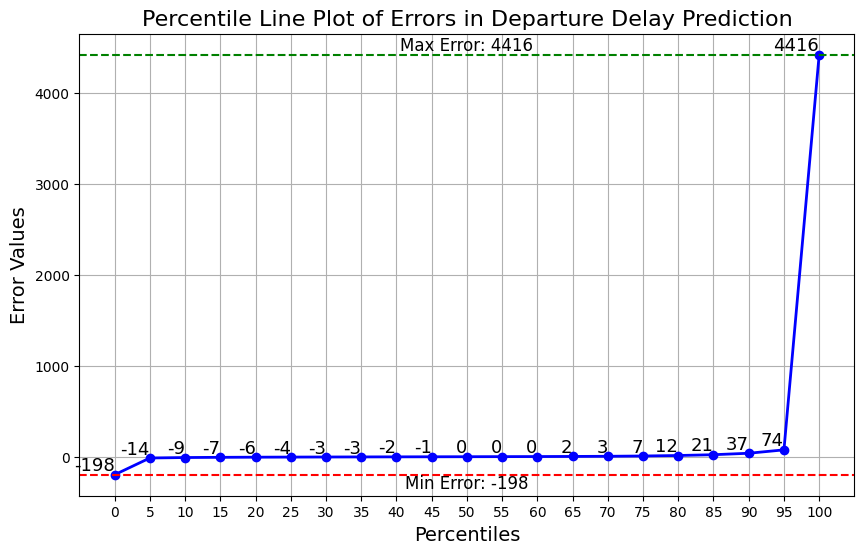

In [10]:
errors = np.array(testing_results["values"]["errors"])

# Calculate the percentiles at 5% intervals
percentiles = np.arange(0, 101, 5)
percentile_values = np.percentile(errors, percentiles)

# Create the line plot
plt.figure(figsize=(10, 6))

# Plot the line connecting the percentiles
plt.plot(percentiles, percentile_values, marker='o', color='b', linestyle='-', linewidth=2, markersize=6)

# Annotate each percentile value on the line
for p, val in zip(percentiles, percentile_values):
    plt.text(p, val, f"{int(val)}", color='black', ha='right', va='bottom', fontsize=13)

# Min value of delays
min_error = int(np.min(errors))
# Max value of delays
max_error = int(np.max(errors))
# Add horizontal lines at the minimum and maximum delays
plt.axhline(y=max_error, color='g', linestyle='--', label=f'Max Error: {max_error}')
plt.axhline(y=min_error, color='r', linestyle='--', label=f'Min Error: {min_error}')

# Add the label text on the same line
# Adjust the x-coordinate to position the label where you want
plt.text(x=50, y=min_error, s=f'Min Error: {min_error}', color='black', fontsize=12, verticalalignment='top', horizontalalignment='center')
plt.text(x=50, y=max_error, s=f'Max Error: {max_error}', color='black', fontsize=12, verticalalignment='bottom', horizontalalignment='center')

# Title and labels
plt.title("Percentile Line Plot of Errors in Departure Delay Prediction", fontsize=16)
plt.xlabel("Percentiles", fontsize=14)
plt.ylabel("Error Values", fontsize=14)

# Set the x-axis ticks to be every 5% (already set by the percentiles)
plt.xticks(np.arange(0, 101, 5))  # Set x-axis ticks from 0 to 100 with step size of 5

# Show the plot
plt.grid(True)
plt.show()